In [86]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
import machinevisiontoolbox as mv


def getcube(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x, 0.5)
    y = np.append(y, 0.5)
    z = np.append(z, 0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    Q = cube.reshape(3, -1)  # cube
    Q = np.swapaxes(Q, 0, 1)
    Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
    ones = np.ones(Q.shape[0]).reshape(Q.shape[0], 1)
    Q = np.concatenate((Q, ones), axis=1)
    Q = np.append(np.vstack(
        (x, np.zeros_like(x), np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), y, np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), np.zeros_like(x), z, np.ones_like(x))).T, Q, axis=0)
    return Q


def projectpoints(K, R, t, Q, printP=False):
    Q.reshape((Q.shape[1], Q.shape[0]))
    T = np.concatenate((R, t), axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i, :]
        projected = P @ p.reshape(4, 1)
        if printP and (Q[i, :] == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
            print(P)
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx, ppsy

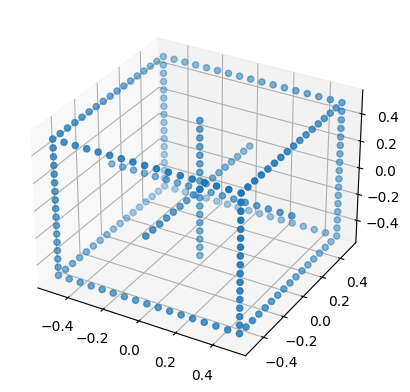

In [87]:
Q = getcube(16)
ax = plt.axes(projection='3d')
ax.scatter3D(Q[:,0],Q[:,1],Q[:,2])

In [88]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320,320),
    "name": "default perspective camera",
}
cam = mv.CentralCamera(**params)
cam, cam.K
K = cam.K

/tmp/ipykernel_416653/1122105371.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppsx.append(float(projected[0]/projected[2]))
/tmp/ipykernel_416653/1122105371.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppsy.append(float(projected[1]/projected[2]))
/home/ernie/.local/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ernie/.local/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width)

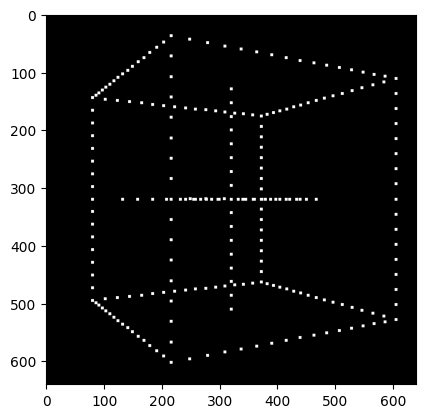

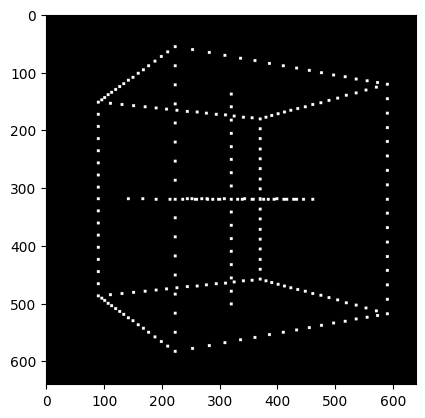

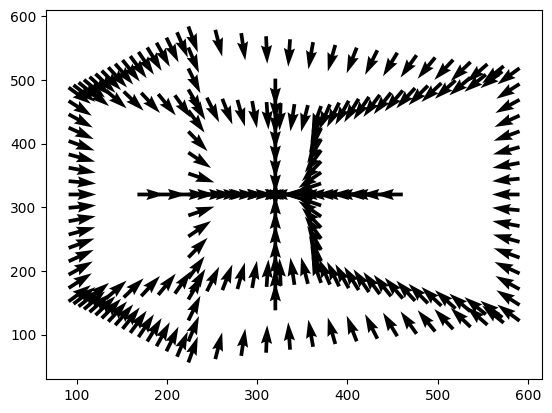

In [96]:
theta = np.pi / 3
R = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)],
])

t = np.array([[0, 0, 2.0]]).T
# for i in range(N):
# plt.figure()
# plt.xlim([-.5, .5])
# plt.ylim([-.5, .5])
# plt.scatter(ppsx, ppsy)  # 2D image
N = 2
images = np.zeros((N, 640, 640))
features = np.zeros((N, Q.shape[0], 2))
flow_vectors = np.zeros((N-1, Q.shape[0], 2))
feature_depth = np.zeros((N, Q.shape[0]))

for i in range(images.shape[0]):
    image = images[i]
    # t = np.array([[i*.1, i*.1, 2.0+i*.1]]).T
    t = t + np.array([[0, 0, .1]]).T
    (ppsx, ppsy) = projectpoints(K, R, t, Q, printP=False)
    (ppsx, ppsy) = np.array(ppsx), np.array(ppsy)
    features[i, :, 0] = ppsx
    features[i, :, 1] = ppsy

    # depth from the camera frame from t to Q
    feature_depth[i, :] = np.sqrt(
        (Q[:, 0] - t[0][0])**2 + (Q[:, 1] - t[1][0])**2 + (Q[:, 2] - t[2][0])**2)

    if i > 0:
        flow_vectors[i-1, :, 0] = features[i, :, 0] - features[i-1, :, 0]
        flow_vectors[i-1, :, 1] = features[i, :, 1] - features[i-1, :, 1]

    # map -.5 to 0, .5 to 640

    for i in range(len(ppsx)):
        x = int(ppsx[i])
        y = int(ppsy[i])
        # color neighboring pixels
        image[y, x] = 1
        for j in range(-2, 3):
            for k in range(-2, 3):
                image[y+j, x+k] = 1

for im in images:
    plt.figure()
    plt.imshow(im, cmap='gray')
plt.figure()
for i in range(1, Q.shape[0]):
    plt.quiver(features[1, i, 0], features[1, i, 1],
               flow_vectors[0, i, 0], flow_vectors[0, i, 1])

In [128]:
J = cam.visjac_p(features[0].T, feature_depth[0])
J.shape

(478, 6)

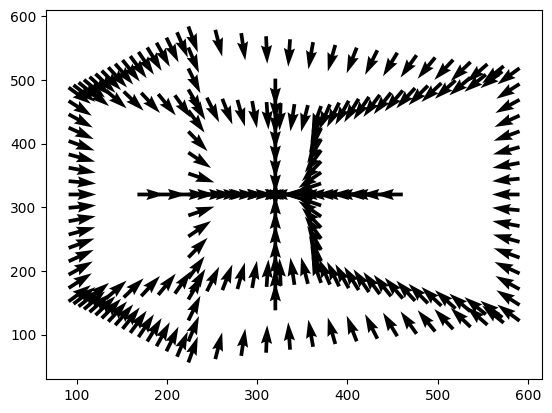

In [150]:
px_flows = np.matmul(J, [0, 0, -.1, 0, 0, 0])
px_flows = px_flows.reshape((-1, 2))

plt.figure()
for i in range(1, Q.shape[0]):
    plt.quiver(features[1, i, 0], features[1, i, 1],
               px_flows[i, 0], px_flows[i, 1])

In [157]:
A = J
b = px_flows.reshape((-1, 1))
x, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
x

array([[-0.000],
       [-0.000],
       [-0.100],
       [0.000],
       [0.000],
       [-0.000]])